# Arshia Yousefinezhad
## 610302085
### HW4 Machine Learning Exercise
### Dr. Babaali


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


تمامی پکیج های لازمه در این قسمت آورده شده

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, RepeatedKFold, cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score

# Question 2


### Read Dataset
با این دستور کد دادگان خوانده شده است

In [ ]:
df_train_data = pd.read_csv('/content/drive/MyDrive/University_of_Tehran/Exercise4/train.csv')
df_test_data = pd.read_csv('/content/drive/MyDrive/University_of_Tehran/Exercise4/test.csv')

## Construct and Train a model

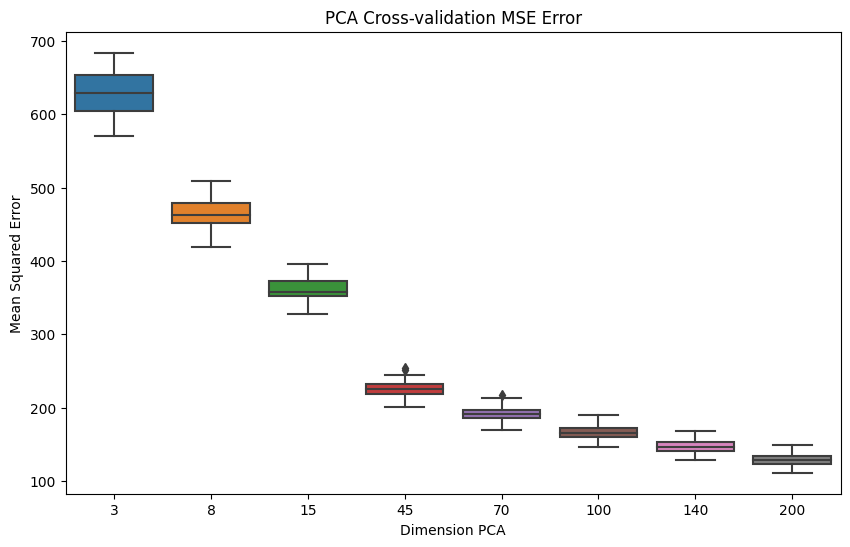

In [ ]:
class PCAModel:
    def __init__(self, num_folds=5, n_repeat=10):
        '''
        Initializes the PCAModel with specified parameters.

        Parameters:
        - num_folds: Number of folds for cross-validation.
        - n_repeat: Number of repeats for cross-validation.
        '''
        self.n_components_range = None
        self.df_scores = None
        self.rkf = RepeatedKFold(n_splits=num_folds, n_repeats=n_repeat, random_state=42)
        self.best_model = None

    def _mean_squared_error_reconstruction(self, model, X):
        '''
        Calculates the mean squared error for PCA reconstruction.

        Parameters:
        - model: PCA model.
        - X: Input data.

        Returns:
        - Mean squared error.
        '''
        X_pca = model.transform(X)
        X_inverse_pca = model.inverse_transform(X_pca)
        return np.mean(np.square(X - X_inverse_pca))

    def train_pca_reconstruction_cv(self, train_data):
        '''
        Trains PCA models with different components using cross-validation.

        Parameters:
        - train_data: Training data.
        '''
        reconstruction_scores = []
        for num_components in self.n_components_range:
            pca = PCA(n_components=num_components)
            scores = cross_val_score(pca, train_data, cv=self.rkf, scoring=self._mean_squared_error_reconstruction)
            reconstruction_scores.append(scores)
        self.df_scores = pd.DataFrame(reconstruction_scores, index=self.n_components_range).T

    def evaluate_pca_reconstruction(self, train_data, test_data, best_component):
        '''
        Evaluates PCA reconstruction on test data and displays images.

        Parameters:
        - train_data: Training data.
        - test_data: Test data.
        - best_component: Number of components for the best PCA model.
        '''
        self.best_model = PCA(n_components=best_component)
        self.best_model.fit(train_data)
        mse_pca = self._mean_squared_error_reconstruction(self.best_model, test_data)
        print("Mean Squared Error on Test data: ", mse_pca)
        self._show_image(test_data)

    def _show_image(self, test_data, n_sample=10):
        '''
        Displays original and reconstructed images side by side.

        Parameters:
        - test_data: Test data.
        - n_sample: Number of samples to display.
        '''
        X_pca = self.best_model.transform(test_data)
        X_inverse_pca = self.best_model.inverse_transform(X_pca)

        images_per_row = 5
        num_rows = int(np.ceil(n_sample / images_per_row))

        plt.figure(figsize=(12, 9))
        for i in range(n_sample):
            plt.subplot(num_rows, images_per_row * 2, i * 2 + 1)
            plt.imshow(test_data[i].reshape(64, 64), cmap='gray')
            plt.axis('off')
            plt.title('Original')

            plt.subplot(num_rows, images_per_row * 2, i * 2 + 2)
            plt.imshow(X_inverse_pca[i].reshape(64, 64), cmap='gray')
            plt.axis('off')
            plt.title('Reconstructed')

        plt.show()

    def box_plot_cv(self):
        '''
        Displays a box plot of cross-validation MSE scores.
        '''
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=self.df_scores)
        plt.title('PCA Cross-validation MSE Error')
        plt.xlabel('Dimension PCA')
        plt.ylabel('Mean Squared Error')
        plt.show()


# Convert DataFrames to NumPy arrays
train_data = df_train_data.to_numpy()
test_data = df_test_data.to_numpy()

# Create an instance of PCAModel
pca_model = PCAModel()

# Set the range of PCA components to analyze
pca_model.n_components_range = [3, 8, 15, 45, 70, 100, 140, 200]

# Train PCA models with cross-validation
pca_model.train_pca_reconstruction_cv(train_data)

# Display box plot of cross-validation results
pca_model.box_plot_cv()


Mean Squared Error on Test data:  156.42991704991906


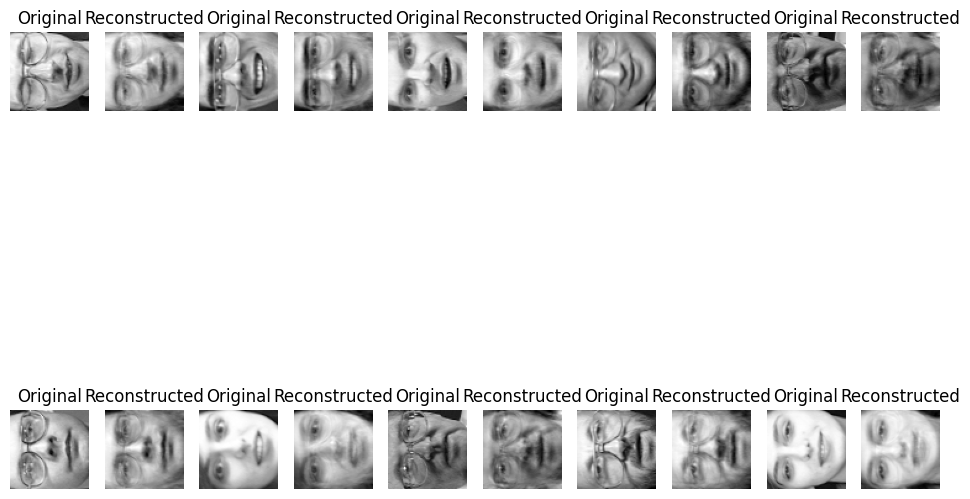

In [ ]:
pca_model.evaluate_pca_reconstruction(train_data, test_data, best_component = 100)


# Question 3

In [ ]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

class BreastCancer:
    def __init__(self, num_folds=5, n_repeat=10):
        """
        BreastCancer class for analyzing breast cancer data using PCA and Perceptron.

        Parameters:
        - num_folds: Number of folds for cross-validation.
        - n_repeat: Number of repeats for cross-validation.
        """
        self.n_components_range = None
        self.df_scores = None
        self.cv_resualts = None

        self.rkf = RepeatedKFold(n_splits=num_folds, n_repeats=n_repeat, random_state=42)

    def normalize_data(self, data):
        """
        Normalize input data using StandardScaler.

        Parameters:
        - data: Input data to be normalized.

        Returns:
        - Normalized data.
        """
        scaler = StandardScaler()
        X_scaler = scaler.fit_transform(data)
        return X_scaler

    def analyze_perceptron_with_pca(self, X, y):
        """
        Analyze breast cancer data using PCA and Perceptron, and generate cross-validation scores.

        Parameters:
        - X: Input features.
        - y: Target labels.
        """
        pca_perceptron_val_scores = []
        pca_perceptron_train_scores = []
        perceptron = Perceptron(random_state=42)

        for num_components in self.n_components_range:
            pca = PCA(n_components=num_components)
            X_pca = pca.fit_transform(X)

            scores = cross_validate(perceptron, X_pca, y, cv=self.rkf, scoring='accuracy', return_train_score=True)

            pca_perceptron_train_scores.append(scores['train_score'])
            pca_perceptron_val_scores.append(scores['test_score'])

            self.cv_resualts = pd.DataFrame({
                'Mean_Train_socres': np.mean(scores['train_score']),
                'Mean_Test_socres': np.mean(scores['test_score']),

            }, index=self.n_components_range).T

        self.df_scores = pd.DataFrame(pca_perceptron_val_scores, index=self.n_components_range).T

    def plot_cross_validation_results(self):
        """
        Plot box plots of cross-validation results for different PCA dimensions.
        """
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=self.df_scores)
        plt.title('Cross-validation Accuracy with PCA and Perceptron')
        plt.xlabel('Number of PCA Components')
        plt.ylabel('Accuracy')
        plt.show()

# Load breast cancer dataset
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target

# Create an instance of BreastCancer
breast_cancer = BreastCancer()

# Set the range of PCA components to analyze
breast_cancer.n_components_range = [2, 3, 4, 5, 10, 15, 20]

# Normalize the data
X_normalized = breast_cancer.normalize_data(X)

# Analyze the data using PCA and Perceptron
breast_cancer.analyze_perceptron_with_pca(X_normalized, y)

# Show train and validation mean socres
breast_cancer.cv_resualts


,2,3,4,5,10,15,20
Mean_Train_socres,0.977241,0.977241,0.977241,0.977241,0.977241,0.977241,0.977241
Mean_Test_socres,0.964673,0.964673,0.964673,0.964673,0.964673,0.964673,0.964673


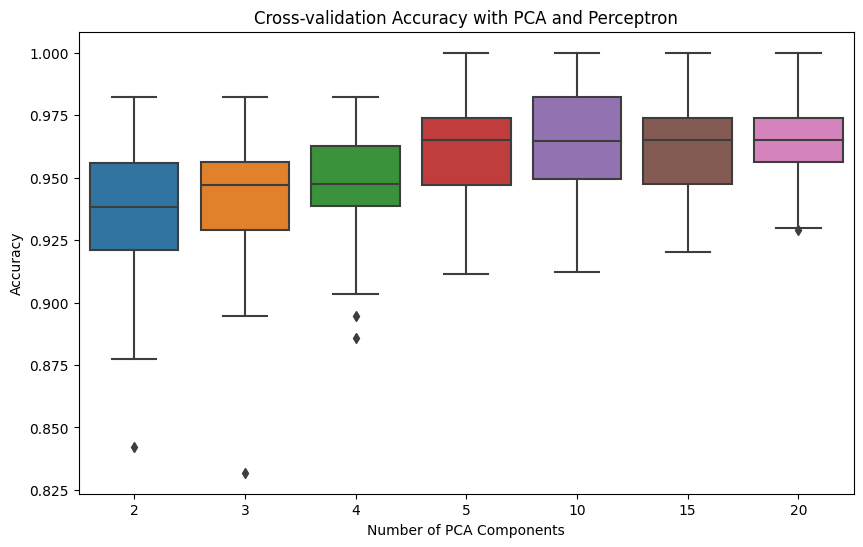

In [ ]:
# Plot cross-validation results
breast_cancer.plot_cross_validation_results()